In [4]:
import pathlib
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pathlib
from GPy.models import GPRegression
import GPy
import pickle
import matplotlib.colors as mcolors
from sklearn.neighbors import KernelDensity
import sys
sys.path.append("./../")
from src.ice_sheet import ice_sheet_runner
import random

from src.utils import load_data, prep_data, predict_and_plot_SLC
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import seaborn as sns
plt.style.use('seaborn-whitegrid')
sns.set_palette('colorblind')
mpl.rcParams['font.family'] = 'Arial'

In [5]:
# Def calculate the optimal value
def calculate_optimal_density(data, sample_size):
    Y_min = 0
    Y_max = 400
    var_bool = True
    #for var_bool in [True,False]:
    data_list = []
    mean,var = predict_and_plot_SLC(data, 175, 600, 2, plot=False, sample_size=sample_size)[1]
    for m,v in zip(mean,var):
        if var_bool:
            data_list += list(np.random.normal(m,np.sqrt(v),size=sample_size))
        else:
            data_list += list(np.random.normal(m,0,size=sample_size))
    X_lin = np.linspace(Y_min,Y_max,100)[:, np.newaxis]
    kde = KernelDensity(kernel='gaussian',bandwidth=1).fit(np.array(data_list).reshape((-1,1))) #you can supply a bandwidth

    log_density_values=kde.score_samples(X_lin)
    y_opt_pdf=np.exp(log_density_values)
    # Calculate optimal CDF
    max_val = 400
    x = []
    y = []
    for thres in range(0,max_val,5):
        # Count how many elements in data list are abov thres
        # and divide by the total number of elements
        # to get the percentage of elements above thres
        x.append(thres)
        y.append(len([i for i in data_list if i > thres])/len(data_list))
    y_opt_cdf = np.array(y)
    return y_opt_cdf, y_opt_pdf


def run(budget,res, y_opt_cdf, y_opt_pdf, plot=False, sample_mean=False,timestamp=199, sample_size=400):
    #res = 4
    #budget = 130
    cost = {2:58,3:12,4:8,5:4,6:3,7:2,8:1}
    num_points = budget//cost[res]
    if num_points < 2:
        return None, None, None
    if num_points > 100:
        num_points = 100
        #return None, None, None
    
    X_m = np.random.lognormal(mean=3,sigma=0.5,size=num_points).reshape((-1,1))
    X_m = np.concatenate([X_m, np.ones((X_m.shape[0],1))*res],axis=1)
    runner = ice_sheet_runner(timestamp=timestamp)
    X = runner.X_clf.transform(X_m)
    Y = runner.run(X)
    X = X[:,0].reshape((-1,1))

    kernel = GPy.kern.RBF(input_dim=1,ARD=True,lengthscale=[1],variance=1)
    model_gpy = GPRegression(X,Y,kernel = kernel, normalizer=True,noise_var=1)
    model_gpy.optimize()

    X_m = np.random.lognormal(mean=3,sigma=0.5,size=sample_size).reshape((-1,1))
    X,Y,X_m = prep_data(data,X_m=X_m)
    #X_m = np.linspace(X_min,X_max,100) # uniform prior
    pred = model_gpy.predict(X_m.reshape((-1,1)))

    mean,var = pred
    data_list = []
    for m,v in zip(mean,var):
        if sample_mean:
            data_list += list(np.random.normal(m,0,size=1))

        else:
            data_list += list(np.random.normal(m,np.sqrt(v),size=sample_size))

    Y_min = 0
    Y_max = 400
    X_lin = np.linspace(Y_min,Y_max,100)[:, np.newaxis]

    kde = KernelDensity(kernel='gaussian',bandwidth=1).fit(np.array(data_list).reshape((-1,1))) #you can supply a bandwidth
                                                                #parameter. 

    log_density_values=kde.score_samples(X_lin)
    Y_pred=np.exp(log_density_values)
    error_pdf = np.abs(Y_pred-y_opt_pdf).sum()

    x = []
    y = []
    for thres in range(0,400,5):
        # Count how many elements in data list are abov thres
        # and divide by the total number of elements
        # to get the percentage of elements above thres
        x.append(thres)
        y.append(len([i for i in data_list if i > thres])/len(data_list))

    error_cdf = np.abs(y-y_opt_cdf).mean()
    return error_pdf,error_cdf , Y_pred, y

def run_simulation(y_opt_cdf, y_opt_pdf):
    res_list = []
    res_list_cdf = []
    timestamp = 175
    res_y_pdf = []
    res_y_cdf = []
    res_Y_pred = []
    print("Timestampt:", timestamp)
    rep = 100
    for res in [2,3,4,5,6,7,8]:
        error_list = []
        error_list_cdf = []
        Y_pred_tmp = []
        for comp in np.arange(59,590,59):
            error_comp = []
            error_comp_cdf = []
            Y_pred_list = []
            # use tqdm to show a progress bar
            for i in tqdm(range(rep)):
                try:
                    error, error_cdf, Y_pdf, y_cdf = run(comp, res, y_opt_cdf, y_opt_pdf, timestamp=timestamp)
                    error_comp.append(error) # Chaneg this to use pdf instead of cdf
                    error_comp_cdf.append(error_cdf)
                    res_y_pdf.append(Y_pdf)
                    res_y_cdf.append(y_cdf)
                except:
                    continue
            if None in error_comp:
                error_list.append(10)
                error_list_cdf.append(10)
            else:
                error_list.append(error_comp)
                error_list_cdf.append(error_comp_cdf)
            Y_pred_tmp.append(Y_pred_list)
        #print("Resolution: ",res,error_list)
        res_list.append(error_list)
        res_Y_pred.append(Y_pred_tmp)
        res_list_cdf.append(error_list_cdf)

    pickle.dump((res_list,res_Y_pred,res_list_cdf),open("fig_6.pkl","wb"))
    return res_list,res_Y_pred,res_list_cdf

In [6]:
# Load data 
data = load_data([0,176])
sample_size = 400 # TEST SIZE, if you want real plots s=3000
y_opt_cdf, y_opt_pdf = calculate_optimal_density(data, sample_size)

use_cached_data = True
if use_cached_data:
    res_list,res_Y_pred,res_list_cdf = pickle.load(open("./../assets/plots_data/fig_6.pkl","rb"))
else:
    res_list,res_Y_pred,res_list_cdf = run_simulation(y_opt_cdf, y_opt_pdf)

 /Users/pierthodo/anaconda3/envs/bayesopt/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning:Mean of empty slice.
 /Users/pierthodo/anaconda3/envs/bayesopt/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning:invalid value encountered in double_scalars


2
[0, 1, 2, 3, 4, 5, 6, 7, 8] [nan, 0.2417357639966151, 0.20837880056279073, 0.20154815057048228, 0.18094149496610784, 0.16417159672411383, 0.17999467076714015, 0.1768095296753886, 0.16652787765860247]
3
[0, 1, 2, 3, 4, 5, 6, 7, 8] [0.21867470735125313, 0.19936335743937084, 0.2033784750266058, 0.19707908972479132, 0.19813078092252123, 0.19743669419426285, 0.19771301927565277, 0.19415600813755524, 0.19305140464633397]
4
[0, 1, 2, 3, 4, 5, 6, 7, 8] [0.30606476308651875, 0.29990184020773836, 0.2993912301298903, 0.30273497593714893, 0.2981777950495083, 0.30270345837575785, 0.3016394907260637, 0.2999144221810408, 0.3055429388926378]
5
[0, 1, 2, 3, 4, 5, 6, 7, 8] [0.37665348398066106, 0.3718081981030118, 0.37180005890429835, 0.3694312965571014, 0.3695497440222262, 0.3656096283674884, 0.36612427602250586, 0.369748358105362, 0.3666944801506744]
6
[0, 1, 2, 3, 4, 5, 6, 7, 8] [0.40906533509524906, 0.4031357067193867, 0.40584161073669106, 0.40254435459342286, 0.40120420766678233, 0.39967861238939

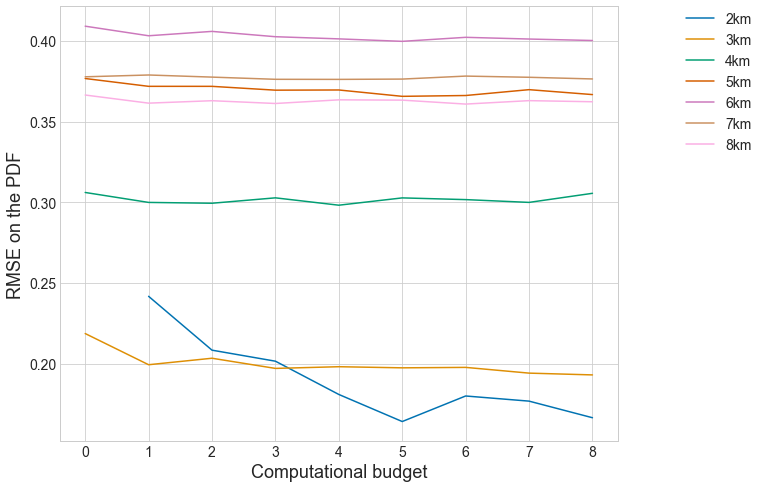

In [9]:
plt.figure(figsize=(10,8))
for c in [res_list]:
    for i,res in zip(c,[2,3,4,5,6,7,8]):
        x =[]
        y = []
        for idx,n in enumerate(i):
            n = np.median(n)
            if n != 10:
                x.append(idx)
                y.append(n) 
        print(res)
        print(x,y)
        plt.plot(x,y,label=str(res)+"km")
    # place legend in top right outside plot
        plt.legend(bbox_to_anchor=(1.25, 1), loc='upper right', borderaxespad=0., fontsize=14)
    #plt.legend()
    plt.xlabel("Computational budget",fontsize=18)
    plt.ylabel("RMSE on the PDF",fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig("./../assets/plots/fig_6/comp.pdf",bbox_inches='tight')

    plt.show()